In [1]:
print('what\'s up')


what's up


# Notebook Import

In [89]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from bs4 import BeautifulSoup
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [113]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'


SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
EASY_NOSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NOSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'


TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'

TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

# Reading Files

In [4]:
stream = open(EXAMPLE_FILE, encoding= 'latin_1')
message = stream.read()
stream.close()
print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [5]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [6]:
stream = open(EXAMPLE_FILE, encoding= 'latin_1')
is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line =='\n':
        is_body = True
stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

 1. A generator-function: is defined like a normal function, but whenever it needs to generate a value, it does so with the    yield keyword rather than return. If the body of a def contains yield, the function automatically becomes a generator function.

 2. Generator-Object : Generator functions return a generator object. Generator objects are used either by calling the next method on the generator object or using the generator object in a “for in” loop.
 
 3. Applications : Suppose we to create a stream of Fibonacci numbers, adopting the generator approach makes it trivial; we just have to call next(x) to get the next Fibonacci number without bothering about where or when the stream of numbers ends.
A more practical type of stream processing is handling large data files such as log files. Generators provide a space efficient method for such data processing as only parts of the file are handled at one given point in time. We can also use Iterators for these purposes, but Generator provides a quick way (We don’t need to write __next__ and __iter__ methods here).
 
 
 
 
 
 

In [7]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [8]:
for i in generate_squares(5):
    print(i, end='->')

0->1->4->9->16->

# Email body extraction

In [9]:
def email_body_generator(path):
    for root,dirnames, filenames in walk(path): #(os library)walk generates the dir, by walking the tree from top to bottom and yields a tuple (di_path,dirnames,filenames)
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding= 'latin_1')
            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line =='\n':
                    is_body = True
            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body   # yield gives output everytime when loop is completed

            

In [10]:
def df_from_directory(path, classification):
    rows=[]
    row_names =[]
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'CATEGORY': classification, 'MESSAGES': email_body })
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index = row_names)

    

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,CATEGORY,MESSAGES
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [12]:
spam_emails.shape

(1002, 2)

In [13]:
ham_emails = df_from_directory(EASY_NOSPAM_1_PATH, HAM_CAT)
ham_emails = spam_emails.append(df_from_directory(EASY_NOSPAM_2_PATH, HAM_CAT))
ham_emails.head()


,CATEGORY,MESSAGES
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [14]:
ham_emails.shape

(2402, 2)

In [15]:
data =pd.concat([spam_emails, ham_emails], join = 'outer')
print('shape of entire dataframe is', data.shape)
data.head()

shape of entire dataframe is (3404, 2)


,CATEGORY,MESSAGES
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [16]:
data.tail()

,CATEGORY,MESSAGES
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."
01400.f897f0931e461e7b2e964d28e927c35e,0,"Hi there,\n\n\n\nNow this is probably of no us..."


# Data Cleaning : Checking for missing values

In [17]:
#check if any message body are equal to null
data['MESSAGES'].isnull().values.any().sum()

0

In [18]:
#check if there are empty emails ( String length is zero)
any(data.MESSAGES.str.len() == 0)

True

In [19]:
(data.MESSAGES.str.len() == 0).sum()  #sums up any true values in the X entries

4

# Locate empty emails

In [20]:
data[data.MESSAGES.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds', 'cmds'], dtype='object')

In [21]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

# Remove system file entries

In [22]:
data.drop(['cmds'], inplace = True)

In [23]:
data.shape

(3400, 2)

# Add document IDs to track emails in dataset

In [24]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [25]:
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    3395
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    3396
01398.169b51731fe569f42169ae8f948ec676    3397
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    3398
01400.f897f0931e461e7b2e964d28e927c35e    3399
Name: DOC_ID, Length: 3400, dtype: int64

In [26]:
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data.head()


,CATEGORY,MESSAGES,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


In [27]:
data.tail()

,CATEGORY,MESSAGES,FILE_NAME
DOC_ID,,,
3395,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
3396,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
3397,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676
3398,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
3399,0,"Hi there,\n\n\n\nNow this is probably of no us...",01400.f897f0931e461e7b2e964d28e927c35e


# Save to file using pandas

In [28]:
data.to_json(DATA_JSON_FILE)

# Number of spam messages visualised (Pie Charts)

In [29]:
data.CATEGORY.value_counts()

1    2000
0    1400
Name: CATEGORY, dtype: int64

In [30]:
amount_of_spam = data.CATEGORY.value_counts()[0]
amount_of_ham = data.CATEGORY.value_counts()[1]

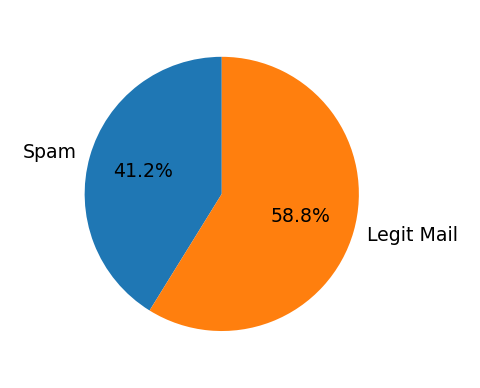

In [31]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize = (2,2), dpi = 227)
plt.pie(sizes, labels = category_names, textprops = {'fontsize': 6}, startangle = 90, autopct = '%1.1f%%' )
plt.show()

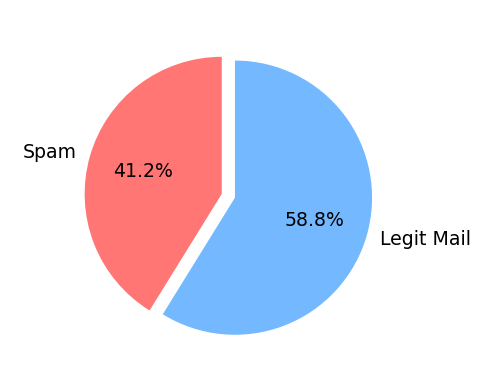

In [32]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675', '#74b9ff']
plt.figure(figsize = (2,2), dpi = 227)
plt.pie(sizes, labels = category_names, textprops = {'fontsize': 6}, startangle = 90, autopct = '%1.1f%%', 
        colors = custom_colors, explode = [0, 0.1] )
plt.show()

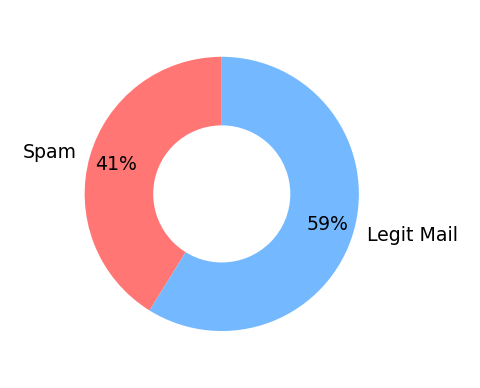

In [33]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#ff7675', '#74b9ff']
plt.figure(figsize = (2,2), dpi = 227)
plt.pie(sizes, labels = category_names, textprops = {'fontsize': 6}, startangle = 90, autopct = '%1.0f%%', 
        colors = custom_colors, pctdistance =0.8 )

#drawing a circle
centre_circle = plt.Circle((0,0), radius =0.5, fc = 'white')
plt.gca().add_artist(centre_circle)
plt.show()

# Natural langusge Processing

### Text Pre-Processing

In [34]:
# converting to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg. lower()

'all work and no play makes jack a dull boy.'

## Download NLTK resourses (Tokensizer & Stopwords)

In [35]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Tokenising

In [36]:
# tokenising example
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing stop words

In [37]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
stop_words = set(stopwords.words('english'))

In [39]:
if 'this' in stop_words: print('Found it')

Found it


In [40]:
if 'hello' in stop_words: print('Found it')
else : print('Nope. not in here')  
    
    
if 'hello' not in stop_words: print('Nope. not in here')    

Nope. not in here
Nope. not in here


In [41]:
# converting to lower case
msg = 'All work and no play makes Jack a dull boy. to be or not to be.'
words = word_tokenize(msg. lower())

filtered_words = []

for word in words:
    if word not in stop_words: filtered_words.append(word)
        
  



## Word stems and Stemming

In [42]:
# converting to lower case
msg = 'All work and no play makes Jack a dull boy. to be or not to be. \
         nobody expects the spanish Inquisition'
words = word_tokenize(msg. lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
  

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing Punctuation

In [43]:
# converting to lower case
msg = 'All work and no play makes Jack a dull boy. to be or not to be. \
         nobody expects the spanish Inquisition'
words = word_tokenize(msg. lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
    if word.isalpha() != False:
        if word not in stop_words:
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
        
  

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


In [44]:
# converting to lower case
msg = 'All work and no play makes Jack a dull boy. to be or not to be. \
         nobody expects the spanish Inquisition'
words = word_tokenize(msg. lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
        if word not in stop_words and word.isalpha():
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
        
  

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags

In [45]:

soup = BeautifulSoup(data.at[2, 'MESSAGES'], 'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [46]:
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

## Functions for email processing 

In [47]:
def clean_messages(message, stemmer =PorterStemmer(),
                   stop_words = set(stopwords.words('english'))):
    # remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    # converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text)
    
    filtered_words = []
    
    for word in words:
        # removes the punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word)
    
    
    return filtered_words

In [48]:
clean_messages(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'now',
 'crux',
 'i',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'but',
 'wait',
 'you',
 'probabl',
 'think',
 'what',
 'make',
 'special',
 'well',
 'first',
 'i',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'i',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'in',
 'addit',
 'gift',
 'all',
 'rang',
 'felt',
 'hoop',
 'holder',
 'you',
 'note',
 'also',
 'enclos',
 'sketch',
 'i',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'i',
 'promis',
 'never',
 'let',
 'i',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'the',
 'timewast',
 'letter',
 'robin',
 'coope

In [49]:
clean_messages(data.at[2, 'MESSAGES'])


['fight',
 'the',
 'risk',
 'cancer',
 'http',
 'slim',
 'down',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'you',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'your',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'have',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'if',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

## Apply Cleaning and Tokenisation to all messages

### Slicing DataFrames and Series & Creating Subsets

In [50]:
data.iat[2,2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [51]:
data.iloc[5:11]

,CATEGORY,MESSAGES,FILE_NAME
DOC_ID,,,
5,1,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,1,Help wanted. We are a 14 year old fortune 500...,00007.d8521faf753ff9ee989122f6816f87d7
7,1,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,00008.dfd941deb10f5eed78b1594b131c9266
8,1,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,1,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",00010.445affef4c70feec58f9198cfbc22997
10,1,Cellular Phone Accessories All At Below Wholes...,00011.61816b9ad167657773a427d890d0468e


In [52]:
first_emails = data.MESSAGES.iloc[0:3]

nested_list = first_emails.apply(clean_messages)

In [53]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)
# len(flat_list)        
        
flat_list = [item for sublist in nested_list for item in sublist]    
    

In [54]:
flat_list

['save',
 'life',
 'insur',
 'whi',
 'spend',
 'more',
 'than',
 'you',
 'have',
 'to',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'we',
 'provid',
 'free',
 'access',
 'the',
 'veri',
 'best',
 'compani',
 'the',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'y',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'you',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'our',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'here',
 'for',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'if',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'here',
 'and',
 'type',
 'remov',
 'if',
 'resid',
 'state',
 'prohibit',
 'solic

In [55]:
%%time
# use apply() on ll the messages in the dataframe
nested_list = data.MESSAGES.apply(clean_messages)

Wall time: 22.3 s


In [56]:
nested_list.tail()

DOC_ID
3395    [http, a, bizarr, collect, stuf, anim, could, ...
3396    [care, use, one, also, realli, cute, thing, ja...
3397    [sm, skip, montanaro, write, jeremi, put, anot...
3398    [so, mark, hammond, like, so, given, zodb, sou...
3399    [hi, now, probabl, use, whatsoev, not, i, also...
Name: MESSAGES, dtype: object

### Using logic to slice DataFrames

In [57]:
data[data.CATEGORY == 1].shape

(2000, 3)

In [58]:
data[data.CATEGORY == 1].tail()

,CATEGORY,MESSAGES,FILE_NAME
DOC_ID,,,
1995,1,<html>\n\n<head>\n\n<title>Toy</title>\n\n</he...,00496.1a37de098f6c8847c3c7839d73cc7106
1996,1,<html>\n\n<head>\n\n<title>Untitled Document</...,00497.ebf699da617b11135f3aa9173b9781b9
1997,1,This is an HTML email message. If you see thi...,00498.48c3098854d339353f1a28a13b196017
1998,1,<html>\n\n<head>\n\n</head>\n\n <body backgro...,00499.988506a852cf86b396771a8bdc8cf839
1999,1,"<STYLE type=""text/css"">\n\n<!--\n\nP{\n\n fon...",00500.85b72f09f6778a085dc8b6821965a76f


In [59]:
doc_ids_spam = data[data.CATEGORY ==1].index
doc_ids_ham = data[data.CATEGORY ==0].index


## Subsetting a Series with an index

In [60]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [61]:
nested_list_ham.shape


(1400,)

In [62]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [63]:
len(doc_ids_spam)
print(doc_ids_ham)

Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
            ...
            3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399],
           dtype='int64', name='DOC_ID', length=1400)


In [64]:
#my answer
def no_of_words(list_):
    length = 0
    for sublist in list_:
        for item in sublist:
            length = length + len(sublist)
    return length   

In [65]:
all_words = no_of_words(nested_list)
all_spam_words = no_of_words(nested_list_spam)
all_ham_words = no_of_words(nested_list_ham)

print('toltal no. of words in the entire list:',all_words)
print('toltal no. of words in the spam list:',all_spam_words)
print('toltal no. of words in the non-spam list:',all_ham_words)


toltal no. of words in the entire list: 584058760
toltal no. of words in the spam list: 384444272
toltal no. of words in the non-spam list: 199614488


In [66]:
#original method
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0]#total no. of unique words in non-spam mesages]


12787

In [67]:
normal_words[:10]

i        5038
http     3251
the      1582
use      1509
list     1494
one      1035
mail     1017
user      952
linux     915
get       905
dtype: int64

In [68]:
#original method
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0]#total no. of unique words in non-spam mesages]


7235

In [69]:
spammy_words[:10]

i         4976
the       3224
you       2736
free      2680
thi       2548
email     2528
http      2488
to        2372
receiv    2188
money     2020
dtype: int64

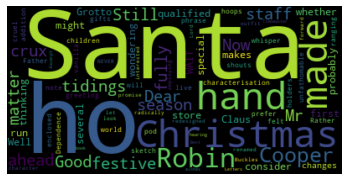

In [70]:
word_cloud = WordCloud().generate(email_body)
plt.axis('off')
plt.imshow(word_cloud, interpolation = 'bilinear')

In [71]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\akash\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\akash\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

In [72]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

# Word Cloud of Ham and Spam Messages

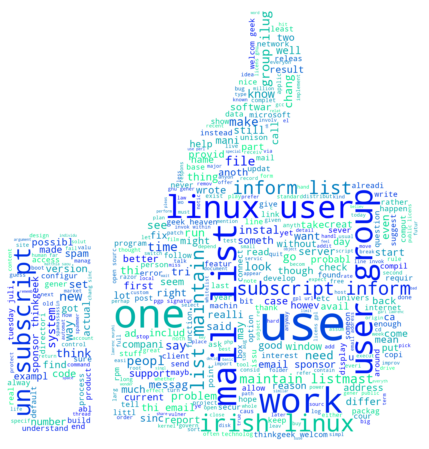

In [73]:
icon =Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size = icon.size, color = (255,255,255))
image_mask.paste(icon, box = icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Gnerate the text as a string for the word cloud

ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask = rgb_array, background_color = 'white', 
                      max_words = 400, colormap = 'winter')

word_cloud.generate(ham_str)

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

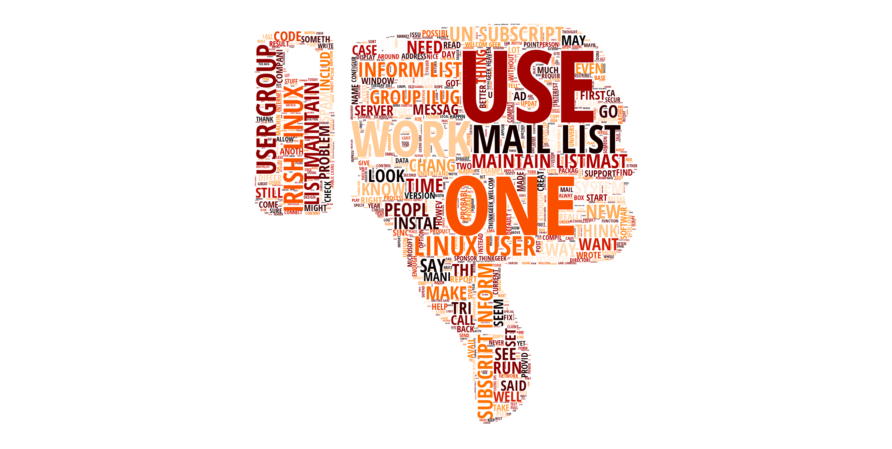

In [74]:
icon =Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size = icon.size, color = (255,255,255))
image_mask.paste(icon, box = icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Gnerate the text as a string for the word cloud

spam_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask = rgb_array, background_color = 'white', 
                      max_words = 2000, colormap = 'gist_heat', font_path = CUSTOM_FONT_FILE, max_font_size=300)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [75]:
stemmed_nested_list = data.MESSAGES.apply(clean_messages)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [76]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 16002


i       10014
http     5739
the      4806
list     3406
thi      3361
dtype: int64

In [77]:
frequent_words = unique_words[0:VOCAB_SIZE ]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 i        10014
http      5739
the       4806
list      3406
thi       3361
you       3127
email     3117
free      2850
get       2781
use       2661
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [78]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index = word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,i
1,http
2,the
3,list
4,thi


## Save the vocabulary as a csv file

In [79]:
vocab.to_csv(WORD_ID_FILE, index_label = vocab.index.name, header = vocab.VOCAB_WORD.name)

### Exercise: Checking if a word is part of the vocabulary

In [80]:
'machine' in set(vocab.VOCAB_WORD)

False

### Exercise: Find the email with the most number of words

In [81]:
#for loop
clean_email_list = []
for sublist in stemmed_nested_list:
    clean_email_list.append(len(sublist))
print(clean_email_list)    

[111, 62, 50, 244, 50, 223, 56, 176, 274, 51, 73, 26, 50, 79, 72, 311, 56, 415, 37, 62, 234, 208, 0, 107, 15, 415, 50, 24, 70, 112, 328, 62, 173, 82, 59, 1297, 55, 160, 2, 96, 84, 5, 56, 83, 50, 90, 45, 23, 46, 69, 56, 89, 80, 86, 29, 314, 37, 69, 21, 20, 15, 42, 85, 20, 82, 32, 132, 49, 277, 73, 130, 5, 54, 0, 42, 42, 231, 0, 42, 176, 72, 127, 72, 267, 1427, 70, 0, 66, 56, 171, 16, 0, 92, 83, 2, 211, 60, 56, 60, 250, 124, 48, 86, 51, 336, 319, 11, 37, 108, 26, 56, 344, 64, 47, 0, 39, 85, 127, 102, 65, 132, 39, 83, 65, 24, 143, 60, 0, 45, 82, 48, 81, 56, 87, 0, 28, 249, 111, 0, 65, 93, 250, 78, 56, 18, 118, 25, 126, 113, 203, 6, 44, 58, 87, 314, 140, 225, 6, 587, 72, 19, 190, 91, 56, 89, 96, 276, 42, 258, 45, 37, 140, 104, 68, 60, 45, 134, 86, 121, 0, 67, 1669, 134, 111, 29, 200, 1, 124, 276, 31, 159, 234, 209, 0, 109, 135, 1785, 0, 134, 178, 124, 46, 179, 46, 46, 0, 0, 428, 207, 82, 376, 15, 107, 105, 118, 419, 305, 254, 160, 281, 15, 108, 156, 242, 71, 99, 242, 238, 138, 42, 109, 232

In [82]:
#Python List comprehension
clean_email_list = [len(sublist) for sublist in stemmed_nested_list]
print('Nr. of words in longest email:', max(clean_email_list))

Nr. of words in longest email: 8133


In [83]:
print('email position in the list (and the data dataframe)', np.argmax(clean_email_list))

email position in the list (and the data dataframe) 3379


In [84]:
stemmed_nested_list[ np.argmax(clean_email_list)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'now',
 'http',
 'a',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'it',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'these',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'the',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'we',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'in',
 'particular',


In [85]:
data.at[np.argmax(clean_email_list), 'MESSAGES']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse matrix

### Creating a DataFrame with one word per column

In [86]:
stemmed_nested_list

DOC_ID
0       [save, life, insur, whi, spend, more, than, yo...
1       [fight, the, risk, cancer, http, slim, down, g...
2       [fight, the, risk, cancer, http, slim, down, g...
3       [adult, club, offer, free, membership, instant...
4       [i, thought, might, like, slim, down, guarante...
                              ...                        
3395    [http, a, bizarr, collect, stuf, anim, could, ...
3396    [care, use, one, also, realli, cute, thing, ja...
3397    [sm, skip, montanaro, write, jeremi, put, anot...
3398    [so, mark, hammond, like, so, given, zodb, sou...
3399    [hi, now, probabl, use, whatsoev, not, i, also...
Name: MESSAGES, Length: 3400, dtype: object

In [87]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,8123,8124,8125,8126,8127,8128,8129,8130,8131,8132
0,save,life,insur,whi,spend,more,than,you,have,to,...,None,None,None,None,None,None,None,None,None,None
1,fight,the,risk,cancer,http,slim,down,guarante,lose,lb,...,None,None,None,None,None,None,None,None,None,None
2,fight,the,risk,cancer,http,slim,down,guarante,lose,lb,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,to,all,site,...,None,None,None,None,None,None,None,None,None,None
4,i,thought,might,like,slim,down,guarante,lose,lb,day,...,None,None,None,None,None,None,None,None,None,None


In [88]:
word_columns_df.shape # 3400 is the no. of emails and 8133 is no. of words in longest email

(3400, 8133)

### Splitting the data into training and testing datasets

In [90]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size = 0.3, random_state=42)

In [91]:
print('Nr of training sample', X_train.shape[0])

Nr of training sample 2380


In [94]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,8123,8124,8125,8126,8127,8128,8129,8130,8131,8132
DOC_ID,,,,,,,,,,,,,,,,,,,,,
2835,on,tue,karl,anderson,wrote,dave,long,write,it,also,...,None,None,None,None,None,None,None,None,None,None
2867,on,jul,karl,anderson,wrote,an,interest,idea,i,heard,...,None,None,None,None,None,None,None,None,None,None
994,from,desmond,steven,urgent,assist,you,may,be,surpris,to,...,None,None,None,None,None,None,None,None,None,None
464,nnaji,standard,trust,bank,ltd,lago,nigeria,dear,sir,i,...,None,None,None,None,None,None,None,None,None,None
2764,i,sure,call,custom,servic,number,unsubscrib,i,took,tri,...,None,None,None,None,None,None,None,None,None,None


In [95]:
y_train.head()

DOC_ID
2835    0
2867    0
994     1
464     1
2764    0
Name: CATEGORY, dtype: int64

### Create a sparse matrix for the training data

In [97]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index)

pandas.core.indexes.base.Index

In [98]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as a dataframe
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    index_words: index of words orderd by word id
    labels: category as a series (y_train or y_test)
    
    """
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                dict_list.append(item)
    
    
    return pd.DataFrame(dict_list)

In [99]:
%%time

sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 4min 43s


In [100]:
sparse_train_df[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,2835,1,62
1,0,2835,1,842
2,0,2835,1,114
3,0,2835,1,1764
4,0,2835,1,319


In [101]:
sparse_train_df.shape

(331435, 4)

In [102]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
331430,0,3174,1,6
331431,0,3174,1,372
331432,0,3174,1,11
331433,0,3174,1,3
331434,0,3174,1,1


## Combine occurences with Pandas groupby() Method

In [103]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
1      1       1              7
       2       1              1
       3       1              2
       5       1              1
       7       1              1

In [105]:
vocab.at[1, 'VOCAB_WORD']

'http'

In [106]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,1,1,1,7
1,1,2,1,1
2,1,3,1,2
3,1,5,1,1
4,1,7,1,1


In [108]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
186801,3399,2252,0,1
186802,3399,2286,0,2
186803,3399,2290,0,1
186804,3399,2458,0,2
186805,3399,2481,0,1


In [109]:
vocab.at[2458, 'VOCAB_WORD']

'nv'

In [110]:
data.MESSAGES[3399]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

## Save Training Data as txt file

In [112]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt = '%d')

In [115]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,8123,8124,8125,8126,8127,8128,8129,8130,8131,8132
DOC_ID,,,,,,,,,,,,,,,,,,,,,
291,regist,and,domain,for,onli,the,new,domain,name,final,...,None,None,None,None,None,None,None,None,None,None
755,thi,multipart,mime,messag,sinc,mail,reader,understand,format,messag,...,None,None,None,None,None,None,None,None,None,None
2096,on,fri,jul,niall,o,broin,wrote,i,know,strictli,...,None,None,None,None,None,None,None,None,None,None
432,untitl,document,you,receiv,mail,member,subscrib,jm,to,unsubscrib,...,None,None,None,None,None,None,None,None,None,None
479,dear,i,well,confid,capabl,assist,transact,mutual,benefit,parti,...,None,None,None,None,None,None,None,None,None,None


In [116]:
y_test.head()

DOC_ID
291     1
755     1
2096    0
432     1
479     1
Name: CATEGORY, dtype: int64

In [118]:
X_test.shape

(1020, 8133)

In [119]:
%%time

sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 2min 2s


In [120]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()                                       

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,2
1,0,3,1,1
2,0,5,1,2
3,0,6,1,2
4,0,7,1,3


In [121]:
test_grouped.shape

(85542, 4)

In [123]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt = '%d')